In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [2]:
# 一些超参数
learning_rate = 1e-3
# 如果有GPU，该脚本将使用GPU进行计算
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
raw_datasets = load_dataset('code_search_net', 'python')
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

In [4]:
class char_tokenizer:

    def __init__(self, data):
        # 数据中出现的所有字符构成字典
        chars = sorted(list(set(''.join(data))))
        # 预留一个位置给结尾的特殊字符
        self.char2ind = {s : i + 1 for i, s in enumerate(chars)}
        self.char2ind['<|e|>'] = 0
        self.ind2char = {i : s for s, i in self.char2ind.items()}

    def encode(self, text):
        return [self.char2ind[c] for c in text]

    def decode(self, enc):
        if isinstance(enc, int):
            return self.ind2char[enc]
        return [self.ind2char[i] for i in enc]

In [5]:
# 举例验证分词器
tok = char_tokenizer(datasets['whole_func_string'])
example_text = 'def post(self):'
''.join(tok.decode(tok.encode(example_text))), len(tok.char2ind)

('def post(self):', 98)

In [6]:
class RNNCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        '''
        循环神经网络的神经元
        参数
        ----
        input_size ：int，输入数据的特征长度
        hidden_size ：int，隐藏状态的特征长度
        '''
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        combined_size = self.input_size + self.hidden_size
        # 使用线性回归模型，由输入数据和上一个隐藏状态得到当前的隐藏状态
        self.i2h = nn.Linear(combined_size, self.hidden_size)

    def forward(self, inputs, hidden=None):
        '''
        向前传播
        参数
        ----
        inputs ：torch.FloatTensor，输入数据，形状为(1, I)，I等于input_size
        hidden ：torch.FloatTensor，上一个隐藏状态，形状为(1, H)，H等于hidden_size
        返回
        ----
        hidden ：torch.FloatTensor，当前隐藏状态
        '''
        # 若无上一个隐藏状态，比如循环神经网络的开端，则生成默认的隐藏状态
        if hidden is None:
            hidden = self.init_hidden(inputs.device)   # (1,     H)
        combined = torch.cat((inputs, hidden), dim=1)  # (1, I + H)
        hidden = F.relu(self.i2h(combined))            # (1,     H)
        return hidden

    def init_hidden(self, device):
        # 默认的隐藏状态全部等于0
        # device用于控制生成张量的设备（cpu或gpu）
        return torch.zeros((1, self.hidden_size), device=device)


class CharRNN(nn.Module):

    def __init__(self, vs):
        '''
        单层的循环神经网络
        参数
        ----
        vs ：int，字典大小
        '''
        super().__init__()
        # 定义文字嵌入的特征长度
        self.emb_size = 30
        # 定义隐藏状态的特征长度
        self.hidden_size = 50
        # 文字嵌入层
        self.embedding = nn.Embedding(vs, self.emb_size)
        # 循环神经网络的神经元
        self.rnn = RNNCell(self.emb_size, self.hidden_size)
        # 语言建模头，根据隐藏状态预测下一个字母是什么
        self.h2o = nn.Linear(self.hidden_size, vs)

    def forward(self, x, hidden=None):
        '''
        向前传播
        参数
        ----
        x ：torch.LongTensor，当前字母在字典中的位置，形状为(1)
        hidden ：torch.FloatTensor，上一个隐藏状态，形状为(1, 50)
        返回
        ----
        output ：torch.FloatTensor，预测结果的logits，形状为(1, vs)
        hidden ：torch.FloatTensor，当前隐藏状态
        '''
        emb = self.embedding(x)         # (1, 30)
        # 得到当前的隐藏状态
        hidden = self.rnn(emb, hidden)  # (1, 50)
        # 预测下一个字母
        output = self.h2o(hidden)       # (1, vs)
        return output, hidden

c_model = CharRNN(len(tok.char2ind)).to(device)

In [7]:
# 通过一个简单的例子验证模型搭建是否正确
inputs = torch.tensor(tok.encode('d'), device=device)
hidden = None
logits, hidden = c_model(inputs, hidden)
logits.shape, hidden.shape

(torch.Size([1, 98]), torch.Size([1, 50]))

In [8]:
@torch.no_grad()
def generate(model, idx, max_new_tokens=300):
    '''
    利用模型生成文本（反复使用模型进行预测）
    参数
    ----
    model ：CharRNN，生成文本的模型
    idx ：torch.LongTensor，当前字母在字典中的位置，形状为(1)
    max_new_tokens ：int，生成文本的最大长度
    返回
    ----
    out ：list[int]，生成的文本
    '''
    out = idx.tolist()
    hidden = None
    # 将模型切换至评估模式
    model.eval()
    for _ in range(max_new_tokens):
        logits, hidden = model(idx, hidden)
        probs = F.softmax(logits, dim=-1)
        # 根据模型预测的概率，得到最终的预测结果（下一个字母）
        # 这一步运算有一定随机性
        ix = torch.multinomial(probs, num_samples=1)
        out.append(ix.item())
        # 注意调整模型输入的形状
        idx = ix.squeeze(0)
        if ix.item() == 0:
            break
    # 将模型切换至训练模式
    model.train()
    return out

In [9]:
# 使用模型来生成文本
begin_text = torch.tensor(tok.encode('d'), device=device)
print(''.join(tok.decode(generate(c_model, begin_text))))

d*ZO(F/of("YP{BZE G|uw=R:1'_$?Q9)N[{KQ=CKfAM:iKca"|+Q3j<sAegWS$ö8Px!q9T3"yum5Za)'W~5\Wm&B"({r
cdtMR^DA11zc<|e|>


In [10]:
def encoding(text):
    '''
    根据文本生成训练数据
    '''
    enc = tok.encode(text)
    # 0表示文本的结束
    return (torch.tensor(enc, device=device), torch.tensor(enc[1:] + [0], device=device))

# 用一个简单的例子展示模型的训练数据
inputs, labels = encoding(example_text)
print(inputs)
print(labels)
for i in range(len(inputs)):
    context = inputs[:i + 1]
    target = labels[i]
    print(f'The input is {inputs[i].unsqueeze(0)}, ' +
          f'the implied input is {context}, the target is {target}')

tensor([70, 71, 72,  2, 82, 81, 85, 86, 10, 85, 71, 78, 72, 11, 28],
       device='cuda:0')
tensor([71, 72,  2, 82, 81, 85, 86, 10, 85, 71, 78, 72, 11, 28,  0],
       device='cuda:0')
The input is tensor([70], device='cuda:0'), the implied input is tensor([70], device='cuda:0'), the target is 71
The input is tensor([71], device='cuda:0'), the implied input is tensor([70, 71], device='cuda:0'), the target is 72
The input is tensor([72], device='cuda:0'), the implied input is tensor([70, 71, 72], device='cuda:0'), the target is 2
The input is tensor([2], device='cuda:0'), the implied input is tensor([70, 71, 72,  2], device='cuda:0'), the target is 82
The input is tensor([82], device='cuda:0'), the implied input is tensor([70, 71, 72,  2, 82], device='cuda:0'), the target is 81
The input is tensor([81], device='cuda:0'), the implied input is tensor([70, 71, 72,  2, 82, 81], device='cuda:0'), the target is 85
The input is tensor([85], device='cuda:0'), the implied input is tensor([70, 7

In [11]:
# 记录模型的损失
lossi = []
epochs = 1
optimizer = optim.Adam(c_model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    for data in datasets:
        inputs, labels = encoding(data['whole_func_string'])
        # 初始化
        hidden = None
        loss = torch.tensor([0.], device=device)
        optimizer.zero_grad()
        lens = inputs.shape[0]
        # 遍历文本，累加模型损失
        for i in range(lens):
            # 使用unsqueeze调整训练数据的形状
            logits, hidden = c_model(inputs[i].unsqueeze(0), hidden)
            loss += F.cross_entropy(logits, labels[i].unsqueeze(0)) / lens
        lossi.append(loss.item())
        loss.backward()
        optimizer.step()

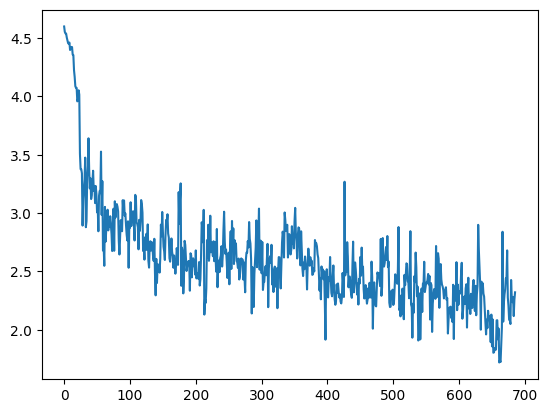

In [12]:
plt.plot(lossi)

In [13]:
# 使用模型来生成文本
begin_text = torch.tensor(tok.encode('d'), device=device)
print(''.join(tok.decode(generate(c_model, begin_text))))

def.areartT    civeif the _are _sext(am pestranatucbyessedevcet "cot che = srd Not Fit the = Notintorn aresTiveb), essingparte = pe "ome   retiothe ted th ches %"ist(mogthar:c_Sy"
      or on Jngien pyrame dor it = veri/g():
    siltonf_ante   """
            sedenv)<|e|>
